# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.

__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [1]:
import os
import pandas as pd
pd.set_option("display.max_columns", 50)
import matplotlib.pyplot as plt
%matplotlib inline

from pyhive import hive
username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Get yourself ready

If you have gone through the exercises by yourself, you are free to go for the questions. If you haven't gone through the exercises, you can follow the next two cells to get all your databases and tables ready.

__In Shell__:

```bash
hdfs dfs -mkdir   -p                              /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    user:hive:r-x             /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m group::r-x                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m other::---                /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:group::r-x        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -R -m default:other::---        /user/${JUPYTERHUB_USER}

hdfs dfs -setfacl -m    user:hive:rwx             /user/${JUPYTERHUB_USER}/hive

hdfs dfs -setfacl -m    default:user:hive:rwx     /user/${JUPYTERHUB_USER}/hive
```

__In Python__:
```python
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)
```

In [2]:
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

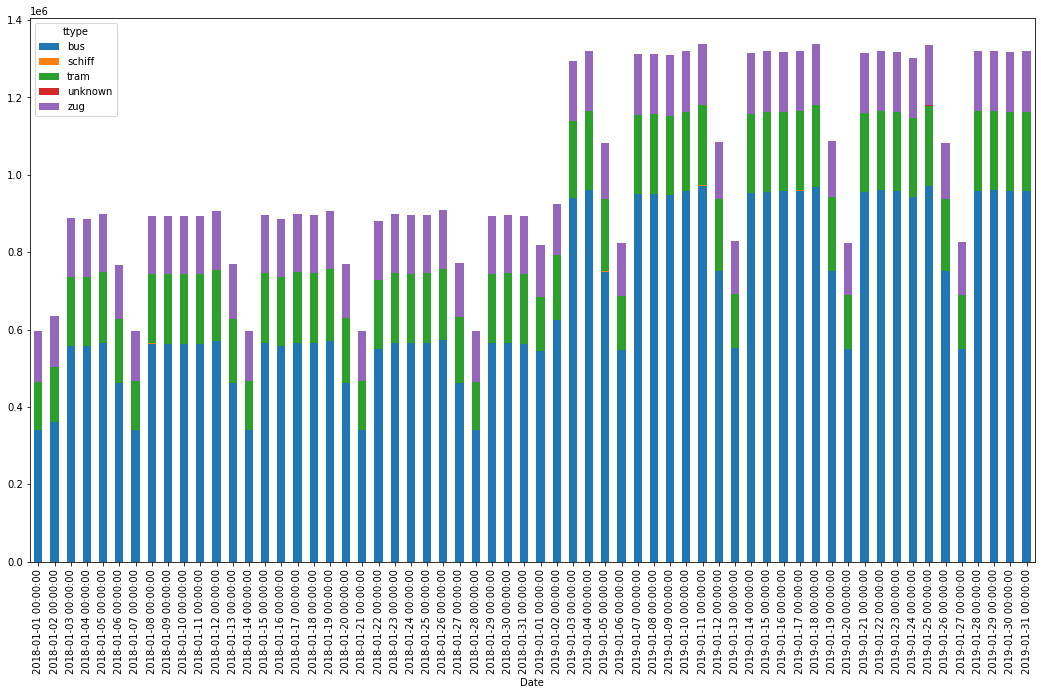

In [27]:
# Fetch number of stops per transport type for each day in January 2018 and 2019
query = """
    SELECT unix_timestamp(BETRIEBSTAG, 'dd.MM.yyyy') AS day, lower(PRODUKT_ID) AS ttype, COUNT(*) AS stops
    FROM {0}.sbb_orc
    WHERE BETRIEBSTAG LIKE '%.01.2018' OR BETRIEBSTAG LIKE '%.01.2019'
    GROUP BY BETRIEBSTAG, lower(PRODUKT_ID)
    ORDER BY day, ttype DESC
""".format(username)
pd.set_option('display.max_rows', None)
total_stops = pd.read_sql(query, conn, parse_dates=['day']) #dates are parsed with parse_dates option
total_stops.replace('', 'unknown', inplace=True) #blank values are changed with unknown

# a pivot table is created for a better chart using day as index and types as columns.
# number of stops will be the values in the columns
pivot_total_stops = total_stops.pivot_table(index='day', values='stops', columns='ttype') 
 
#pivot table is plotted as a stacked bar chart
pivot_total_stops.plot(kind='bar',stacked=True,rot=1, figsize=(18,10))
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.show()

#It can be seen in the graph that SBB services got improved in 2019 compared to 2018. Especially bus stops improved really much.
#It can be seen that SBB offers less stops in weekends. Especially on Sundays.


### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [48]:
# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2019
""".format(username)
cur.execute(query)


# Create the table of one day which is not weekend or special day
query = """
    create table {0}.sbb_05_11_2019
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2019'
""".format(username)
cur.execute(query)

#Actual Query, take unix time to sort the schedule, departure is from Geneve and time is taken as expected
#Additional trips are omited since they are not offered everyday
#Second query selects the trains with type IC and sort them regarding their departure times.
query = """
    with Times as(
        select upper(VERKEHRSMITTEL_TEXT) as stype, 
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_unix, 
               ABFAHRTSZEIT as expected,
               ZUSATZFAHRT_TF as additional,
               LINIEN_ID as id
        from {0}.sbb_05_11_2019
        where HALTESTELLEN_NAME like 'Genève' 
    )
    select id, expected 
    from Times
    where stype = 'IC'
    and additional = 'false'
    and expected != "" 
    order by expected_unix
    LIMIT 100
""".format(username)
df2=pd.read_sql(query, conn)
df2

,id,expected
0,707,05.11.2019 05:42
1,511,05.11.2019 06:12
2,709,05.11.2019 06:42
3,504,05.11.2019 06:47
4,513,05.11.2019 07:15
5,702,05.11.2019 07:20
6,711,05.11.2019 07:42
7,1606,05.11.2019 07:47
8,515,05.11.2019 08:15
9,704,05.11.2019 08:20


### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [14]:
query = """
    select date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM') as month_year, AN_PROGNOSE_STATUS as astatus,count(*) as count 
    from {0}.sbb_orc
    where LINIEN_ID like '733'
      and lower(LINIEN_TEXT) like 'ic%' 
      and  HALTESTELLEN_NAME like 'Lausanne'
    group by date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM'), AN_PROGNOSE_STATUS
    order by month_year
""".format(username)
df = pd.read_sql(query, conn)

In [15]:
df.head()

,month_year,astatus,count
0,2018.01,PROGNOSE,1
1,2018.01,GESCHAETZT,30
2,2018.02,PROGNOSE,1
3,2018.02,GESCHAETZT,27
4,2018.03,PROGNOSE,2


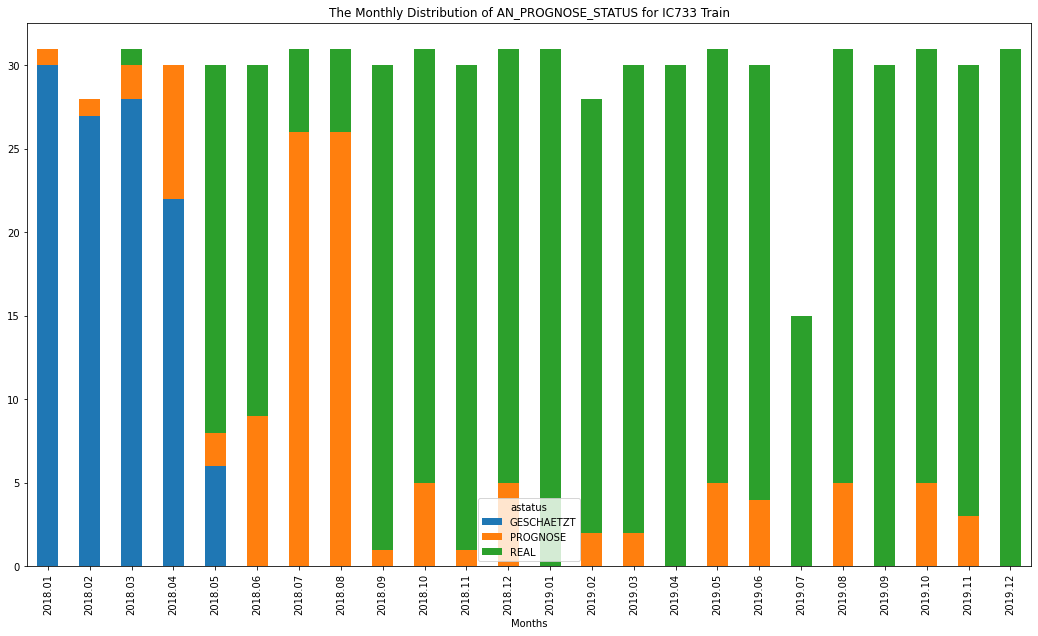

In [31]:
pivot_df = df.pivot(index='month_year', columns='astatus', values='count')
pivot_df.plot.bar(stacked=True, figsize=(18,10))
plt.xlabel('Months')
plt.title('The Monthly Distribution of AN_PROGNOSE_STATUS for IC733 Train')
plt.show()

ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for all the trains that arrived at Lausanne station. Document any anything you observed.

In [20]:
query = """
    select date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM') as month_year, AN_PROGNOSE_STATUS as astatus,count(*) as count 
    from {0}.sbb_orc
    where HALTESTELLEN_NAME like 'Lausanne'
    group by date_format(TO_DATE(FROM_UNIXTIME(UNIX_TIMESTAMP(BETRIEBSTAG, 'dd.MM.yyyy'))),'yyyy.MM'), AN_PROGNOSE_STATUS
    order by month_year
""".format(username)
df_lausanne = pd.read_sql(query, conn)

In [21]:
df_lausanne.head()

,month_year,astatus,count
0,2018.01,PROGNOSE,3595
1,2018.01,GESCHAETZT,13208
2,2018.01,UNBEKANNT,2
3,2018.02,UNBEKANNT,2
4,2018.02,PROGNOSE,3270


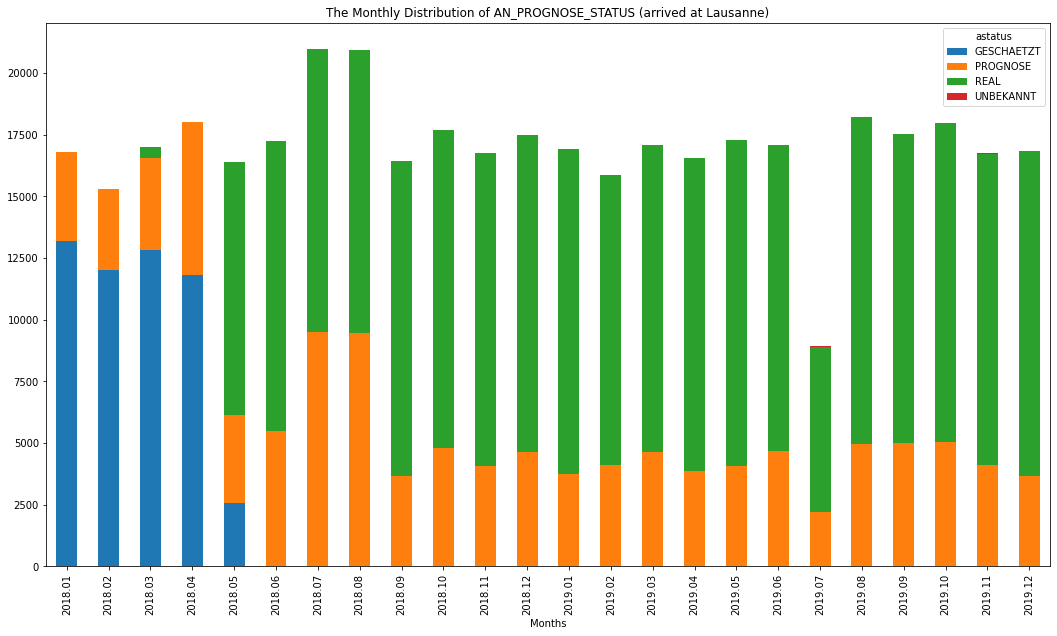

In [32]:
pivot_df = df_lausanne.pivot(index='month_year', columns='astatus', values='count')
pivot_df.plot.bar(stacked=True, figsize=(18,10))
plt.title('The Monthly Distribution of AN_PROGNOSE_STATUS (arrived at Lausanne)')
plt.xlabel('Months')
plt.show()

In both of the graphs in the in the first 4 months of 2018 the number of trains with AN_PROGNOSE_STATUS Estimated(Geschätzt) are very high, which decreases in 05.2018. Starting from 06.2018, there is no Estimated(Geschätzt) status, which might refer to a change about the way SBB calculates the actual time. Probably they have decided not using the estimated time but the "REAL" arrival time as AN_PROGNOSE, since starting from 06.2018 the number of "REAL" AN_PROGNOSE_STATUS increases rapidly.

Distribution of AN_PROGNOSE_STATUS of both the trips by train IC733 and all trains arrived in Lausanne are mostly similar except a few differences. 
The number of 'REAL's in 07.2018 and 08.2018 in the first graph is significantly higher. 

In both graphs, in July 2019 the number of trips abruptly decreases. According to my research, in 07.2019 there were many cancelled trips because of the heatwave which caused deformation in the railway tracks.

### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of one minute and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

In [221]:
query = """
    drop table if exists {0}.sbb_time_1
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_time_1
    stored as parquet
    as 
        select upper(VERKEHRSMITTEL_TEXT) as stype, ABFAHRTSZEIT,AB_PROGNOSE,ANKUNFTSZEIT,AN_PROGNOSE,
        linien_id as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_departure,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Lausanne' AND linien_id = "733" AND verkehrsmittel_text = "IC"
""".format(username)
cur.execute(query)

In [222]:
query = """
    drop table if exists {0}.sbb_delays_1
""".format(username)
cur.execute(query)
query = """
    create table {0}.sbb_delays_1
    stored as parquet
    as 
        SELECT *, 
    CASE
        WHEN actual_departure >= expected_departure THEN ceil((actual_departure - expected_departure)/60.0)
        WHEN actual_departure < expected_departure THEN 0
        ELSE NULL
    END AS delay_departure,
    CASE
        WHEN actual_arrival >= expected_arrival OR  actual_arrival < expected_arrival THEN ceil((actual_arrival - expected_arrival)/60.0)
        ELSE NULL
    END AS delay_arrival
    FROM {0}.sbb_time_1
""".format(username)
cur.execute(query)

In [223]:
query = """
    SELECT  delay_departure, count(*) as count
    FROM {0}.sbb_delays_1
    where delay_departure is not NULL
    group by delay_departure
    order by delay_departure
    
""".format(username)
df_delay_departure = pd.read_sql(query, conn)

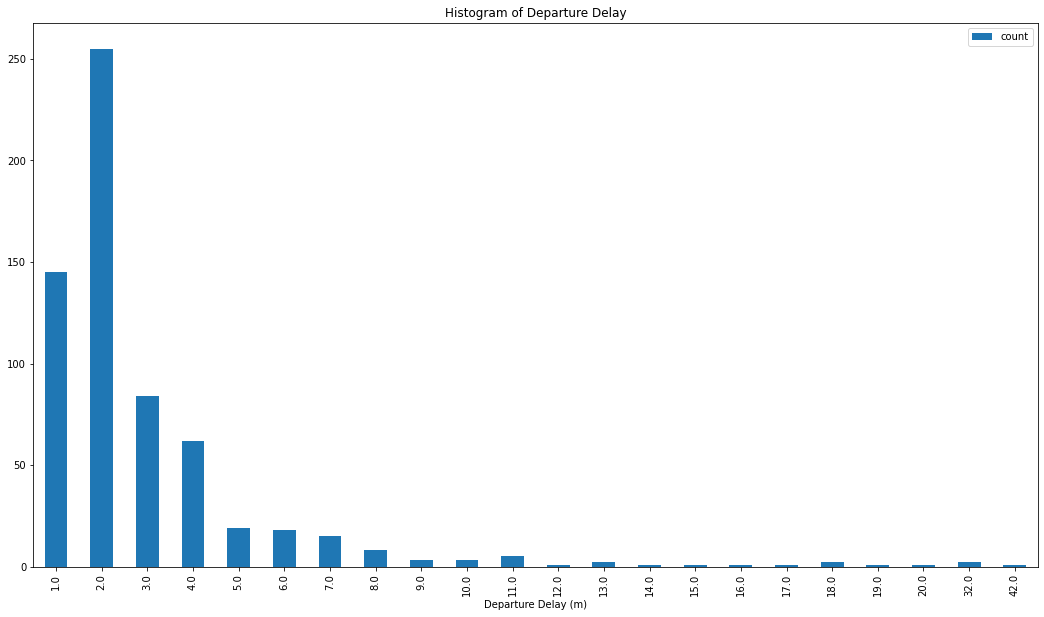

In [225]:
df_delay_departure.plot("delay_departure","count",kind='bar',figsize=(18,10))
plt.xlabel('Departure Delay (m)')
plt.title('Histogram of Departure Delay')
plt.show()

In [226]:
query = """
    SELECT delay_arrival, count(*) as count
        FROM (SELECT   CASE
                            WHEN delay_arrival < 0 then 0
                            ELSE delay_arrival
                        END AS delay_arrival
            FROM {0}.sbb_delays_1) as d
    where delay_arrival is not NULL
    group by delay_arrival
    order by delay_arrival
    
""".format(username)
df_delay_arrival = pd.read_sql(query, conn)

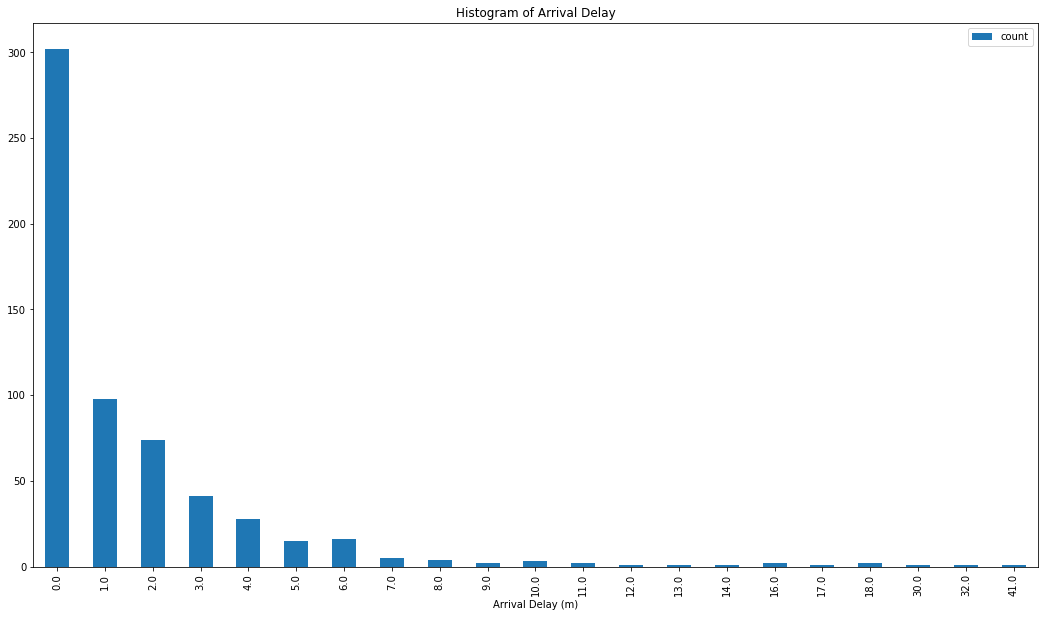

In [227]:
df_delay_arrival.plot("delay_arrival","count",kind='bar',figsize=(18,10))
plt.xlabel('Arrival Delay (m)')
plt.title('Histogram of Arrival Delay')
plt.show()

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

In [228]:
query = """
    drop table if exists {0}.sbb_time_2
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_time_2
    stored as parquet
    as 
        select upper(VERKEHRSMITTEL_TEXT) as stype,
            upper(linien_id) as id,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_departure,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Genève' AND CAST(linien_id AS int) BETWEEN 702 AND 730 AND verkehrsmittel_text = "IC"
""".format(username)
cur.execute(query)

In [229]:
query = """
    drop table if exists {0}.sbb_delays_2
""".format(username)
cur.execute(query)
query = """
    create table {0}.sbb_delays_2
    stored as parquet
    as 
        SELECT stype,id,
    CASE
        WHEN actual_departure >= expected_departure THEN actual_departure - expected_departure
        WHEN actual_departure < expected_departure THEN 0
        ELSE NULL
    END AS delay_departure,
    CASE
        WHEN actual_arrival >= expected_arrival THEN actual_arrival - expected_arrival
        WHEN actual_arrival < expected_arrival THEN 0
        ELSE NULL
    END AS delay_arrival
    FROM {0}.sbb_time_2
""".format(username)
cur.execute(query)

In [230]:
query = """
SELECT  id,
    percentile(delay_departure,0.5) as 50th_percentile,
    percentile(delay_departure,0.75) as 75th_percentile
FROM {0}.sbb_delays_2
GROUP BY id
ORDER BY id
    
""".format(username)
df_percentiles_departure = pd.read_sql(query, conn)
df_percentiles_departure

,id,50th_percentile,75th_percentile
0,702,64.0,96.00
1,704,103.0,190.50
2,706,95.0,179.50
3,707,76.0,108.00
4,708,107.5,220.75
5,709,84.0,122.00
6,710,73.0,149.00
7,711,90.0,143.00
8,712,80.0,135.50
9,713,100.5,175.50


In [231]:
query = """
SELECT  id,
    percentile(delay_arrival,0.5) as 50th_percentile,
    percentile(delay_arrival,0.75) as 75th_percentile
FROM {0}.sbb_delays_2
GROUP BY id
ORDER BY id
    
""".format(username)
df_percentiles_arrival = pd.read_sql(query, conn)
df_percentiles_arrival

,id,50th_percentile,75th_percentile
0,702,16.5,77.50
1,704,36.0,125.50
2,706,37.0,134.50
3,707,NaN,NaN
4,708,49.0,175.00
5,709,22.0,63.25
6,710,24.0,109.50
7,711,12.0,50.75
8,712,4.5,65.00
9,713,66.0,146.00


iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour and visualize your results. Can you find the tendency and interpret?

In [232]:
query = """
    drop table if exists {0}.sbb_time_3
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_time_3
    stored as parquet
    as 
        select upper(VERKEHRSMITTEL_TEXT) as stype,
            upper(linien_id) as id,
            ABFAHRTSZEIT,
            substr(ABFAHRTSZEIT,12,2) as hour,
               unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected_departure, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_departure,
               unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected_arrival, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual_arrival
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Lausanne'
        """.format(username)
cur.execute(query)

In [233]:
query = """
    drop table if exists {0}.sbb_delays_3
""".format(username)
cur.execute(query)
query = """
    create table {0}.sbb_delays_3
    stored as parquet
    as 
        SELECT stype,id,ABFAHRTSZEIT,hour,
    CASE
        WHEN actual_departure > expected_departure THEN actual_departure - expected_departure
        WHEN actual_departure < expected_departure THEN 0
        ELSE NULL
    END AS delay_departure,
    CASE
        WHEN actual_arrival > expected_arrival THEN actual_arrival - expected_arrival
        WHEN actual_arrival < expected_arrival THEN 0
        ELSE NULL
    END AS delay_arrival
    FROM {0}.sbb_time_3
""".format(username)
cur.execute(query)

In [234]:
query = """
SELECT  hour,
    percentile(delay_departure,0.25) as 25th_percentile,
    percentile(delay_departure,0.5) as 50th_percentile,
    percentile(delay_departure,0.75) as 75th_percentile
FROM {0}.sbb_delays_3
where hour != ""
GROUP BY hour
ORDER BY hour
    
""".format(username)
df_percentiles_hourly = pd.read_sql(query, conn)
df_percentiles_hourly

,hour,25th_percentile,50th_percentile,75th_percentile
0,00,48.00,79.0,189.0
1,01,55.00,93.0,210.0
2,02,38.25,59.0,111.0
3,03,30.00,44.0,75.0
4,04,37.00,48.0,71.0
5,05,38.00,53.0,77.0
6,06,44.00,63.0,106.0
7,07,49.00,75.0,143.0
8,08,51.00,82.0,162.0
9,09,48.00,70.0,134.0


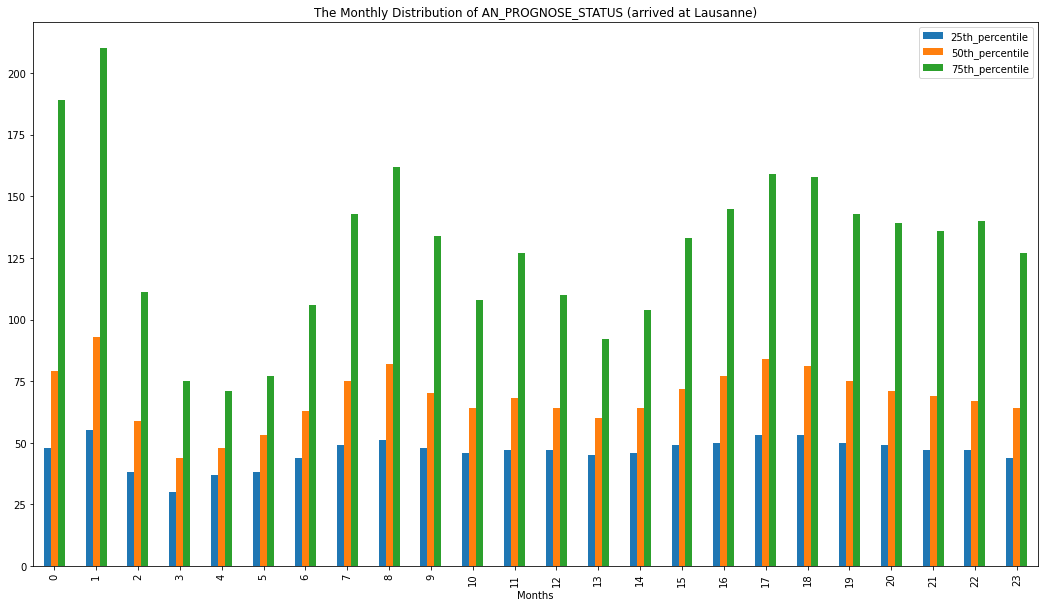

In [235]:
df_percentiles_hourly.plot.bar(figsize=(18,10))
plt.title('The Monthly Distribution of AN_PROGNOSE_STATUS (arrived at Lausanne)')
plt.xlabel('Months')
plt.show()

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

In [ ]:
query = """
     SELECT HALTESTELLEN_NAME, AB_PROGNOSE, ABFAHRTSZEIT, BETRIEBSTAG, UNIX_TIMESTAMP(AB_PROGNOSE, 'dd.MM.yyyy HH:mm') as abpunix, UNIX_TIMESTAMP(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') as abfunix 
     FROM {0}.sbb_orc
     WHERE HALTESTELLEN_NAME LIKE 'Genève' AND
        UPPER(VERKEHRSMITTEL_TEXT) LIKE 'TGV' AND
        AB_PROGNOSE != '' AND
        UNIX_TIMESTAMP(ABFAHRTSZEIT, 'dd.MM.yyyy HH:mm') < UNIX_TIMESTAMP(AB_PROGNOSE, 'dd.MM.yyyy HH:mm') AND
        ABFAHRTSZEIT != ''
        LIMIT 100
""".format(username)
df = pd.read_sql(query,conn,parse_dates=['ab_prognose','abfahrtszeit'])
#
query = """
        SELECT HALTESTELLEN_NAME, AN_PROGNOSE, ANKUNFTSZEIT, BETRIEBSTAG, UNIX_TIMESTAMP(AN_PROGNOSE, 'dd.MM.yyyy HH:mm') as anpunix, UNIX_TIMESTAMP(ANKUNFTSZEIT, 'dd.MM.yyyy HH:mm') as ankunix 
        FROM {0}.sbb_orc
        WHERE HALTESTELLEN_NAME LIKE 'Lausanne' AND
            UPPER(VERKEHRSMITTEL_TEXT) LIKE 'TGV' AND
            AN_PROGNOSE != '' AND
            UNIX_TIMESTAMP(AN_PROGNOSE, 'dd.MM.yyyy HH:mm') <= UNIX_TIMESTAMP(ANKUNFTSZEIT, 'dd.MM.yyyy HH:mm') AND
            ANKUNFTSZEIT != '' 
        LIMIT 100
""".format(username)
df2 = pd.read_sql(query,conn,parse_dates=['an_prognose','ankunftszeit' ])
df3 = pd.merge(df, df2, how='outer', on='betriebstag')
df4 = df3.dropna(axis=0, subset=['an_prognose', 'ab_prognose', 'anpunix', 'abpunix','ankunix' ,'abfunix' ])
df5 = df4.loc[abs(df3.anpunix - df3.abpunix) <= 2400 ]
df5.loc[abs(df3.anpunix > df3.abpunix)]

In [28]:
# For testing purposes only
query = """
    DESCRIBE FORMATTED {0}.sbb_orc
""".format(username)
pd.read_sql(query,conn)

,col_name,data_type,comment
0,# col_name,data_type,comment
1,betriebstag,string,
2,fahrt_bezeichner,string,
3,betreiber_id,string,
4,betreiber_abk,string,
5,betreiber_name,string,
6,produkt_id,string,
7,linien_id,string,
8,linien_text,string,
9,umlauf_id,string,


In [35]:
# For testing purposes only
query = """
    select * from {0}.sbb_orc limit 5
""".format(username)
pd.read_sql(query, conn)

,sbb_orc.betriebstag,sbb_orc.fahrt_bezeichner,sbb_orc.betreiber_id,sbb_orc.betreiber_abk,sbb_orc.betreiber_name,sbb_orc.produkt_id,sbb_orc.linien_id,sbb_orc.linien_text,sbb_orc.umlauf_id,sbb_orc.verkehrsmittel_text,sbb_orc.zusatzfahrt_tf,sbb_orc.faellt_aus_tf,sbb_orc.bpuic,sbb_orc.haltestellen_name,sbb_orc.ankunftszeit,sbb_orc.an_prognose,sbb_orc.an_prognose_status,sbb_orc.abfahrtszeit,sbb_orc.ab_prognose,sbb_orc.ab_prognose_status,sbb_orc.durchfahrt_tf
0,29.11.2019,80:06____:17012:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17012,RE,,RE,false,false,8500090,Basel Bad Bf,,,PROGNOSE,29.11.2019 06:34,,UNBEKANNT,false
1,29.11.2019,80:06____:17013:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17013,RE,,RE,false,false,8500090,Basel Bad Bf,29.11.2019 06:25,,UNBEKANNT,,,PROGNOSE,false
2,29.11.2019,80:06____:17014:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17014,RE,,RE,false,false,8500090,Basel Bad Bf,,,PROGNOSE,29.11.2019 09:48,,UNBEKANNT,false
3,29.11.2019,80:06____:17015:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17015,RE,,RE,false,false,8500090,Basel Bad Bf,29.11.2019 08:06,,UNBEKANNT,,,PROGNOSE,false
4,29.11.2019,80:06____:17016:000,80:06____,DB,DB Regio AG Baden-Württemberg,Zug,17016,RE,,RE,false,false,8500090,Basel Bad Bf,,,PROGNOSE,29.11.2019 10:48,,UNBEKANNT,false
